# Planetary Nebula Production <a class="tocSkip">
    
This notebook is used to test and showcase the results of my first project. I use spectroscopic data from the [Multi Unit Spectroscopic Explorer](https://www.eso.org/sci/facilities/develop/instruments/muse.html) (MUSE) that has been observed as part of the [PHANGS](https://sites.google.com/view/phangs/home) collaboration.
    
I will use a set of line maps of emission lines to identify Planetary Nebula in the data an measure their brightness. This can then be used to fit an empiric relation and hence measure the distance to the galaxy.
    
This notebook is used for developement. Final code is moved to the `pymuse` packge in the `src` folder. Any production scripts reside in the `scripts` folder.

## Preparation
 
### Load Basic Packages
    
First we load a bunch of common packages that are used across the project. More specific packages that are only used in one section are loaded later to make it clear where they belong to (this also applies to all custom moduls that were written for this project).

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

# some basic packages
import os                 # filesystem related stuff
import json
from pathlib import Path  # use instead of os.path and glob
import sys                # mostly replaced by pathlib

import errno      # more detailed error messages
import warnings   # handles warnings
import logging    # use logging instead of print

from collections import OrderedDict  

# packages for scientific computing
import numpy as np
import scipy as sp

# packages for creating plots and figures
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# special functions for astronomy 
from astropy.table import Table  # useful datastructure
from astropy.table import vstack # combine multiple tables

from astropy.io import fits      # open fits files
from astropy.io import ascii     # handle normal files

from astropy.wcs import WCS               # handle coordinates
from astropy.coordinates import Angle     # work with angles (e.g. 1°2′3″)
from astropy.coordinates import SkyCoord  # convert pixel to sky coordinates
from astropy.visualization import simple_norm

from astropy.stats import sigma_clipped_stats  # calcualte statistics of images

import astropy.units as u        # handle units

tab10 = ['#e15759','#4e79a7','#f28e2b','#76b7b2','#59a14e','#edc949','#b07aa2','#ff9da7','#9c755f','#bab0ac']    
plt.style.use('TeX.mplstyle')

we use the `logging` module to handle informations and warnings (this does not always work as expected in jupyter notebooks).

In [2]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)

### Read in data

this uses the `ReadLineMaps` class from the `pymuse.io` module. To use it, we first need to specify the path to the data folder

IC5332, NGC628, NGC1087, NGC1365, NGC1512, NGC1566, NGC1672, NGC2835, NGC3351, NGC3627, NGC4254, NGC4535, NGC5068

In [239]:
from pymuse.io import ReadLineMaps

name = 'NGC3627'

# first we need to specify the path to the raw data
data_raw = Path('d:\downloads\MUSEDAP')
basedir = Path('..')

# list all files in the specified directory
galaxies = [x.name for x in data_raw.iterdir() if x.is_dir()]
#print(', '.join(map(str,galaxies)))

extensions = ['OIII5006', 'HA6562', 'NII6583', 'SII6716','HB4861']

# read in the data we will be working with and print some information
galaxy = ReadLineMaps(data_raw / name,extensions)

with fits.open(data_raw / name / f'{name}_starmask.fits') as hdul:
    star_mask = hdul[0].data

av_file = data_raw / name / f'{name}_AV.fits'
if av_file.is_file():    
    with fits.open(av_file) as hdul:
        galaxy.Av = hdul[0].data
else:
    print('no Av map')
    
mask = np.zeros(galaxy.shape,dtype=bool)
mask |= star_mask.astype(bool)

INFO:pymuse.io:loading NGC3627
INFO:pymuse.io:replacing OIII5006 map
INFO:pymuse.io:file loaded with 5 extensions


In [ ]:
# look at the masks
#mask[300:650,500:900]=True # NGC1365
mask[600:900,250:450]=True #NGC3627

img = galaxy.OIII5006_DAP.copy()

img[mask] = np.nan

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot()

norm = simple_norm(galaxy.OIII5006_DAP,clip=False,max_percent=95)
ax.imshow(img,norm=norm,origin='lower')

## Source Detection

In [4]:
from photutils import DAOStarFinder            # DAOFIND routine to detect sources
from photutils import IRAFStarFinder           # IRAF starfind routine to detect star

from pymuse.detection import detect_unresolved_sources

In [240]:
with open(basedir / 'data' / 'interim' / 'parameters.json') as json_file:
    parameters = json.load(json_file)
    
setattr(galaxy,'binsize',parameters[galaxy.name]['binsize'])
setattr(galaxy,'mu',parameters[galaxy.name]['mu'])
setattr(galaxy,'alpha',parameters[galaxy.name]['power_index'])
setattr(galaxy,'completeness_limit',parameters[galaxy.name]['completeness_limit'])
setattr(galaxy,'roundness',parameters[galaxy.name]['roundness'])
setattr(galaxy,'sharplo',parameters[galaxy.name]['sharplo'])
setattr(galaxy,'sharphi',parameters[galaxy.name]['sharphi'])
setattr(galaxy,'threshold',parameters[galaxy.name]['threshold'])
setattr(galaxy,'zoomin',parameters[galaxy.name]['zoomin'])


threshold = galaxy.threshold
oversize  = 1.

roundness = 0.8 #galaxy.roundness
sharplo   = 0.0 #galaxy.sharplo
sharphi   = 0.8 #galaxy.sharphi

print(f'threshold: {threshold}\nround:     {roundness}\nsharplo:   {sharplo}\nsharphi:   {sharphi}')

sources = detect_unresolved_sources(galaxy,
                                    'OIII5006_DAP',
                                    StarFinder=DAOStarFinder,
                                    threshold=threshold,
                                    exclude_region=mask,
                                    oversize=oversize,
                                    roundlo=-roundness,
                                    roundhi=roundness,
                                    sharplo=sharplo,
                                    sharphi=sharphi,
                                    exclude_border=True,
                                    save=False)

threshold: 3
round:     0.8
sharplo:   0.0
sharphi:   0.8
masking 5.93 % of the image
INFO:pymuse.detection:searching for sources in NGC3627 with [OIII5006_DAP] line map (using DAOStarFinder)

INFO:pymuse.detection:     fwhm   #N    mean  median     std
INFO:pymuse.detection:  3.320px  201  72.477  67.869  52.279
INFO:pymuse.detection:  3.570px  212  44.940  39.955  40.062
INFO:pymuse.detection:  3.590px  432  70.983  64.602  60.724
INFO:pymuse.detection:  3.645px  129  87.735  86.127  58.526
INFO:pymuse.detection:  3.655px  176  78.542  73.993  61.880
INFO:pymuse.detection:  3.775px  177  65.283  58.417  56.092
INFO:pymuse.detection:  3.920px  404  32.778  24.213  35.451
INFO:pymuse.detection:  4.640px  172  67.227  61.712  55.441
INFO:pymuse.detection:  total   1903


## Completeness limit

In [14]:
from pymuse.detection import completeness_limit

for IC5332
masking 18.13 % of the image
INFO:pymuse.detection:iteration 1 of 5
INFO:pymuse.detection:360 mock sources created
INFO:pymuse.detection:mock sources inserted into image
INFO:pymuse.detection:769 sources found
INFO:pymuse.detection:compare detected sources to injected sources
INFO:pymuse.detection:iteration 2 of 5
INFO:pymuse.detection:360 mock sources created
INFO:pymuse.detection:mock sources inserted into image
INFO:pymuse.detection:745 sources found
INFO:pymuse.detection:compare detected sources to injected sources
INFO:pymuse.detection:iteration 3 of 5
INFO:pymuse.detection:360 mock sources created
INFO:pymuse.detection:mock sources inserted into image
INFO:pymuse.detection:758 sources found
INFO:pymuse.detection:compare detected sources to injected sources
INFO:pymuse.detection:iteration 4 of 5
INFO:pymuse.detection:360 mock sources created
INFO:pymuse.detection:mock sources inserted into image
INFO:pymuse.detection:744 sources found
INFO:pymuse.detection:compare detec

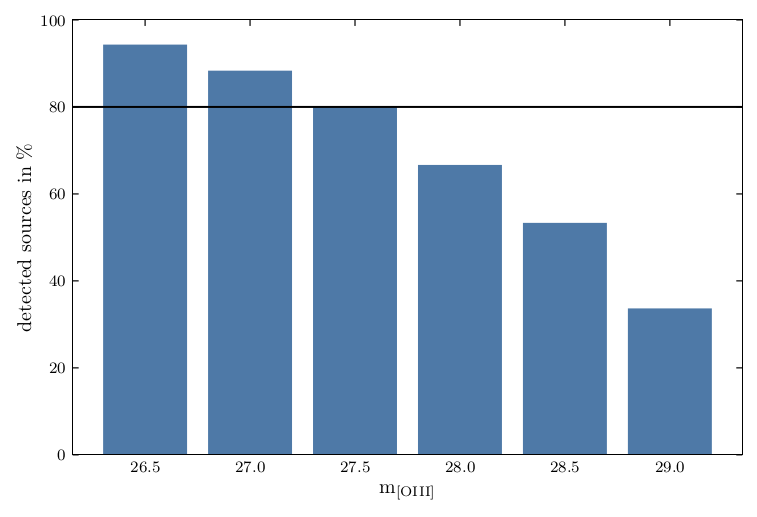

In [113]:
print(f'for {galaxy.name}')
mock_sources = completeness_limit(
                    galaxy,
                    'OIII5006_DAP',
                    DAOStarFinder,
                    threshold=threshold,
                    iterations=5,
                    stars_per_mag=60,
                    exclude_region=mask,
                    oversize=oversize,
                    roundlo=-roundness,
                    roundhi=roundness,
                    sharplo=sharplo,
                    sharphi=sharphi,
                    exclude_border=True,
                    plot=False
                                 )

## Flux measurement

In the previous step we detected potential PN candidates by their [OIII] emission. This means we know their position but lack exact flux measurments. In this section we measure the flux of the identified objects in different emission lines that are used in later steps. 

In [170]:
from pymuse.photometry import measure_flux, light_in_moffat

In [255]:
Rv  = 3.1
Ebv = 0.062

flux = measure_flux(galaxy,sources,alpha=galaxy.alpha,Rv=Rv,Ebv=Ebv,aperture_size=1.5)
# calculate astronomical coordinates for comparison
flux['SkyCoord'] = SkyCoord.from_pixel(flux['x'],flux['y'],galaxy.wcs)

# calculate magnitudes from measured fluxes
flux['mOIII'] = -2.5*np.log10(flux['OIII5006']*1e-20) - 13.74
flux['dmOIII'] = np.abs( 2.5/np.log(10) * flux['OIII5006_err'] / flux['OIII5006'] )

INFO:pymuse.photometry:measuring fluxes in NGC3627 for 1903 sources
INFO:pymuse.photometry:measuring fluxes in [OIII5006] line map
INFO:pymuse.photometry:measuring fluxes in [HA6562] line map
INFO:pymuse.photometry:measuring fluxes in [NII6583] line map
INFO:pymuse.photometry:measuring fluxes in [SII6716] line map
INFO:pymuse.photometry:measuring fluxes in [HB4861] line map
622
INFO:pymuse.photometry:lambda5006: Av=0.22
INFO:pymuse.photometry:lambda6562: Av=0.16
INFO:pymuse.photometry:lambda6583: Av=0.16
INFO:pymuse.photometry:lambda6716: Av=0.15
INFO:pymuse.photometry:lambda4861: Av=0.22
INFO:pymuse.photometry:all flux measurements completed


## Emission line diagnostics    

In [257]:
#galaxy.completeness_limit = 28
#galaxy.mu = 30.4

from pymuse.analyse import emission_line_diagnostics
print(f'emission line diagnostics for {galaxy.name}')
print(f'mu={galaxy.mu:.2f}, cl={galaxy.completeness_limit}')
tbl = emission_line_diagnostics(flux,galaxy.mu,galaxy.completeness_limit)

if False:
    filename = basedir / 'data' / 'catalogues' / f'pn_candidates_{galaxy.name}.txt'
    with open(filename,'w',newline='\n') as f:
        tbl['RaDec'] = tbl['SkyCoord'].to_string(style='hmsdms',precision=2)
        for col in tbl.colnames:
            if col not in ['id','RaDec','type']:
                tbl[col].info.format = '%.3f' 
        ascii.write(tbl[['id','type','x','y','RaDec','OIII5006','OIII5006_err','mOIII','dmOIII',
                         'HA6562','HA6562_err','HA6562_detection','NII6583','NII6583_err','NII6583_detection',
                         'SII6716','SII6716_err','SII6716_detection']][tbl['type']!='NaN'],
                    f,format='fixed_width',delimiter='\t',overwrite=True)
    print('data saved to ' + str(filename))   

emission line diagnostics for NGC3627
mu=30.12, cl=28
INFO:pymuse.analyse:1903 entries in initial catalogue
INFO:pymuse.analyse:1225 not detected in OIII5006
INFO:pymuse.analyse:1067 not detected in HA6562
INFO:pymuse.analyse:1138 not detected in NII6583
INFO:pymuse.analyse:1308 not detected in SII6716
INFO:pymuse.analyse:v_sigma: median=74.53, median=66.28, sig=39.45
INFO:pymuse.analyse:696 rows contain NaN values
INFO:pymuse.analyse:1343 objects below the completness limit of 28
INFO:pymuse.analyse:0 objects classified as 4<log [OIII]/Ha
INFO:pymuse.analyse:406 (290) objects classified as HII
INFO:pymuse.analyse:462 (179) objects classified as SNR
INFO:pymuse.analyse:339 (91) objects classified as PN


In [183]:
filename = basedir / 'data' / 'catalogues' / f'pn_candidates_{galaxy.name}.txt'
with open(filename,'w',newline='\n') as f:
    tbl['RaDec'] = tbl['SkyCoord'].to_string(style='hmsdms',precision=2)
    for col in tbl.colnames:
        if col not in ['id','RaDec','type']:
            tbl[col].info.format = '%.3f' 
    ascii.write(tbl[['id','type','x','y','RaDec','OIII5006','OIII5006_err','mOIII','dmOIII',
                     'HA6562','HA6562_err','HA6562_detection','NII6583','NII6583_err','NII6583_detection',
                     'SII6716','SII6716_err','SII6716_detection']][tbl['type']!='NaN'],
                f,format='fixed_width',delimiter='\t',overwrite=True)
print('data saved to ' + str(filename))   

data saved to ..\data\catalogues\pn_candidates_NGC3351.txt


### Visualize the result of the classification

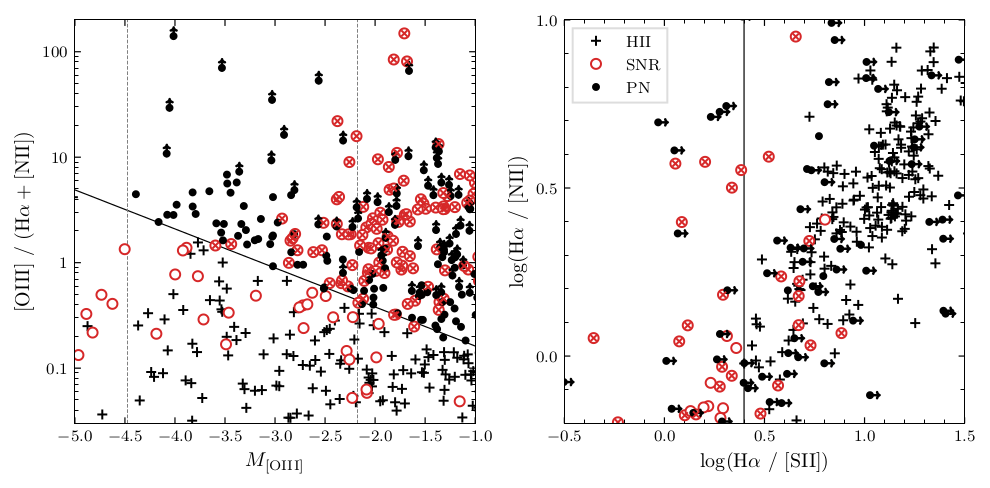

In [126]:
from pymuse.plot.pnlf import plot_emission_line_ratio
filename = basedir / 'reports' / f'{galaxy.name}_emission_line'
plot_emission_line_ratio(tbl,galaxy.mu,completeness=galaxy.completeness_limit,filename=filename)

222 sources
SNR:  51
PN :  73


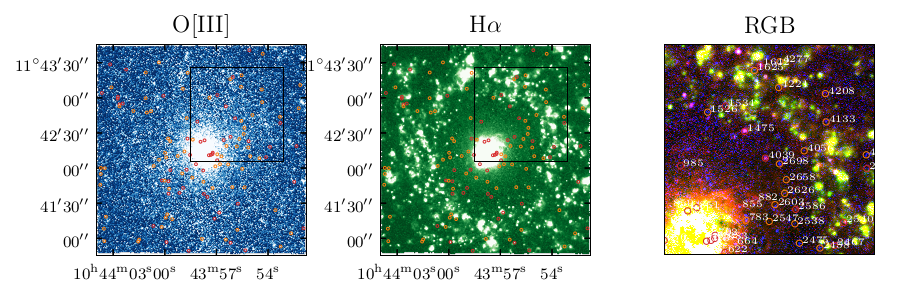

In [184]:
from pymuse.plot.classification import classification_map
#parameters[galaxy.name]['zoomin'] = [200,600,400,800]
filename = basedir / 'reports' / f'{galaxy.name}_detections_classification.pdf'
classification_map(galaxy,parameters,tbl,filename)

## Planetary nebula luminosity function

In [258]:
tbl_old = tbl.copy()

completeness limit = 28
INFO:pymuse.analyse:initialize fitter with 88 data points
INFO:pymuse.analyse:30.215+0.049-0.123


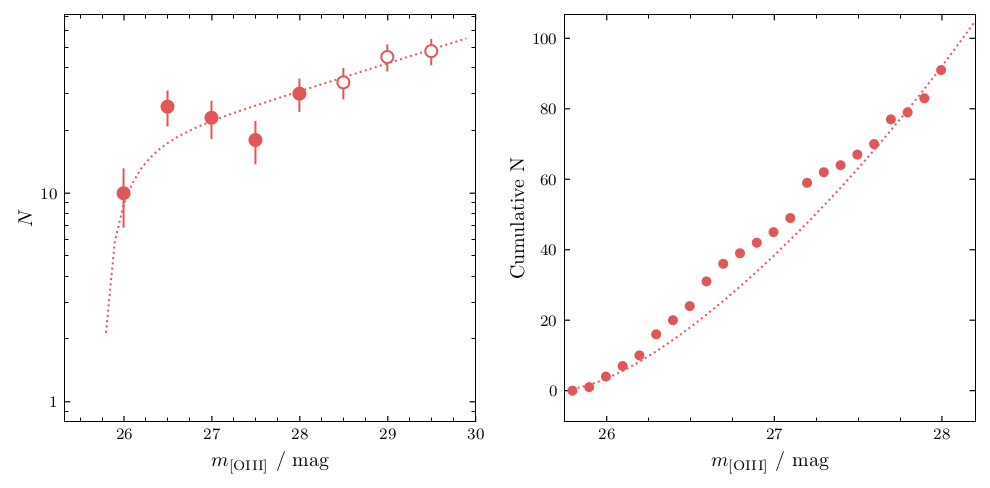

In [283]:
from pymuse.analyse import MaximumLikelihood1D, PNLF, pnlf
from pymuse.plot.pnlf import plot_pnlf

slow  = 0.0
shigh = 0.8
r     = 0.8

binsize=0.5
cut = 25.3

tbl = tbl_old[(sources['sharpness']>slow) & (sources['sharpness']<shigh) & (np.abs(sources['roundness1'])<r)]

criteria = (tbl['type']=='PN') #| (tbl['SNRorPN'])
data = tbl[np.where(criteria & (cut<tbl['mOIII']) & (tbl['mOIII']<galaxy.completeness_limit))]['mOIII']

print(f'completeness limit = {galaxy.completeness_limit}')
fitter = MaximumLikelihood1D(pnlf,data,mhigh=galaxy.completeness_limit)
galaxy.mu,dp,dm = fitter([24])

filename = basedir / 'reports' / 'test' / f'{10*slow:.0f},{10*shigh:.0f},{10*r:.0f}'
filename= None
axes = plot_pnlf(tbl[criteria]['mOIII'],galaxy.mu,galaxy.completeness_limit,binsize=binsize,mhigh=30,filename=filename,color=tab10[0])


completeness limit = 28
INFO:pymuse.analyse:initialize fitter with 39 data points
NGC1566: literature 30.078
INFO:pymuse.analyse:31.184+0.045-0.127


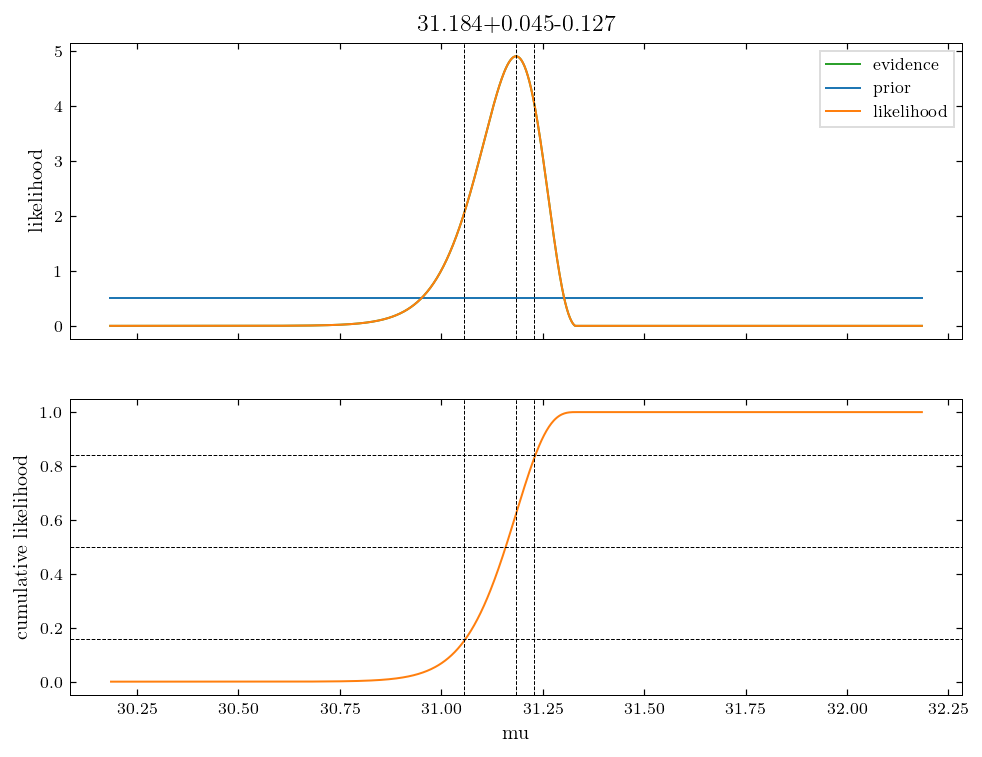

In [94]:
from pymuse.analyse import MaximumLikelihood1D, PNLF, pnlf

#galaxy.completeness_limit = 27.5
cut = 26.5

print(f'completeness limit = {galaxy.completeness_limit}')
criteria = (tbl['type']=='PN')
data = tbl[np.where(criteria & (cut<tbl['mOIII']) & (tbl['mOIII']<galaxy.completeness_limit))]['mOIII']
err  = tbl[np.where(criteria & (cut<tbl['mOIII']) & (tbl['mOIII']<galaxy.completeness_limit))]['dmOIII']

fitter = MaximumLikelihood1D(pnlf,
                             data,
                             #err=err,
                             mhigh=galaxy.completeness_limit)

# a good guess would be mu_guess = min(data)-Mmax
print(f'{galaxy.name}: literature {galaxy.mu:.3f}')
galaxy.mu,dp,dm = fitter([24])
fitter.plot()
#dm_p, dm_m = np.sqrt(np.mean(err)**2+np.array([dm_p,dm_m])**2)

### Plot the fit

to plot the fit we need to bin the data

plotting result for NGC1566 (binsize=0.5)


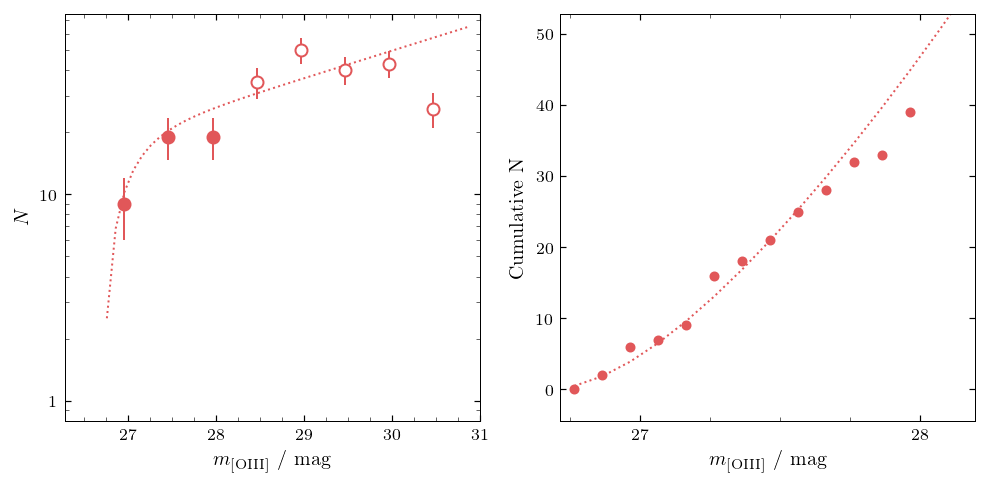

In [95]:
from pymuse.plot.pnlf import plot_pnlf
binsize =  galaxy.binsize
print(f'plotting result for {galaxy.name} (binsize={binsize})')
filename = basedir / 'reports' / f'{galaxy.name}_PNLF'
filename= None
axes = plot_pnlf(tbl[criteria]['mOIII'],galaxy.mu,galaxy.completeness_limit,binsize=binsize,mhigh=31,filename=filename,color=tab10[0])


### Compare to literature

NGC3627


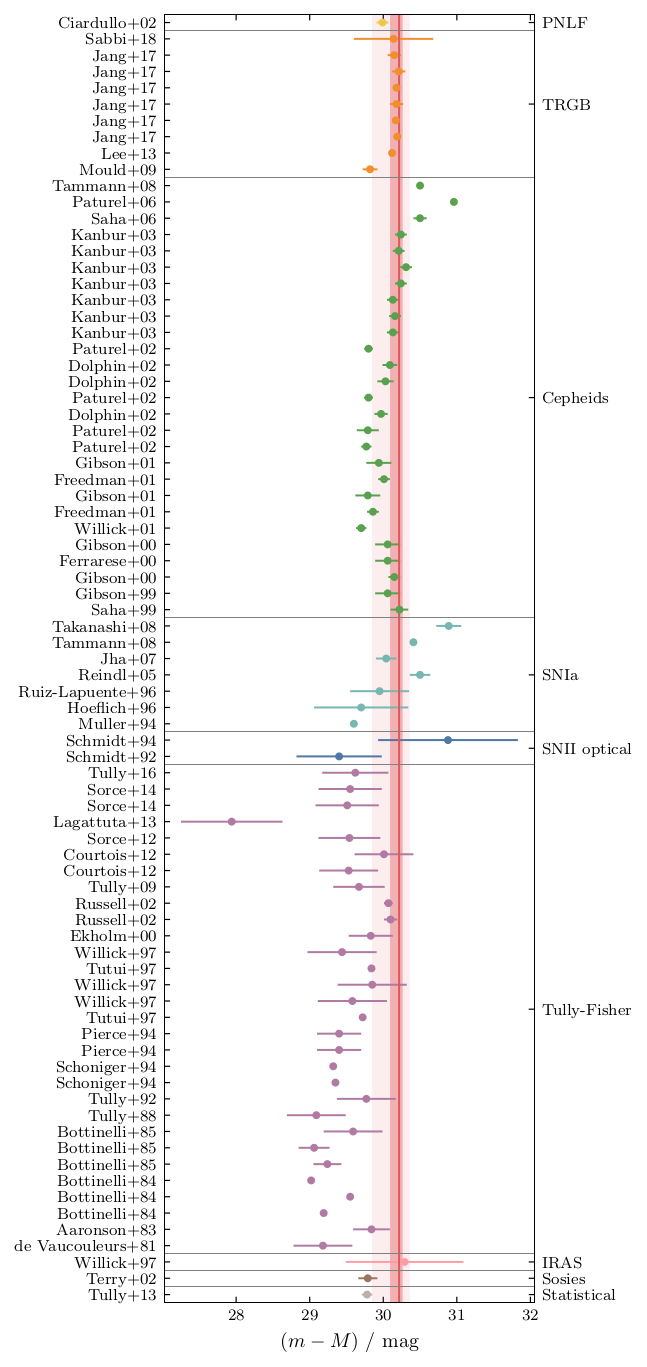

In [284]:
from pymuse.plot.pnlf import compare_distances
print(galaxy.name)
filename = basedir / 'reports' / f'{galaxy.name}_distances'
compare_distances(galaxy.name,galaxy.mu,dp,dm,filename)

### With and without SNR

NGC1566: literature 30.967
completeness limit = 28
INFO:pymuse.analyse:initialize fitter with 34 data points
INFO:pymuse.analyse:30.967+0.037-0.157
INFO:pymuse.analyse:initialize fitter with 75 data points
INFO:pymuse.analyse:30.723+0.011-0.085
plotting result for NGC1566 (binsize=0.4)


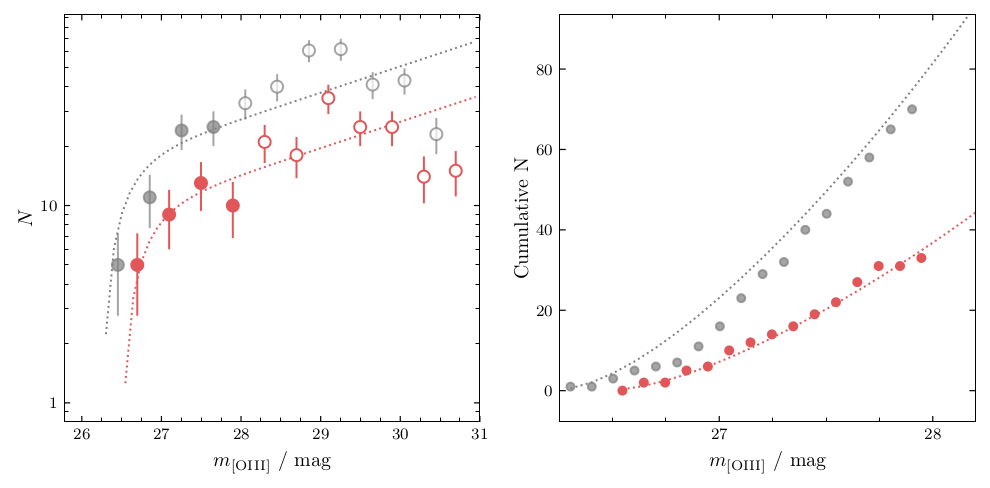

In [238]:
from pymuse.analyse import MaximumLikelihood1D, PNLF, pnlf
from pymuse.plot.pnlf import plot_pnlf

#galaxy.completeness_limit = 28.5
cut = 26.

criteria1 = (tbl['type']=='PN')
data1 = tbl[np.where(criteria1 & (cut<tbl['mOIII']) & (tbl['mOIII']<galaxy.completeness_limit))]['mOIII']
err1  = tbl[np.where(criteria1 & (cut<tbl['mOIII']) & (tbl['mOIII']<galaxy.completeness_limit))]['dmOIII']

criteria2 = (tbl['type']=='PN')| (tbl['SNRorPN'])
data2 = tbl[np.where(criteria2 & (cut<tbl['mOIII']) & (tbl['mOIII']<galaxy.completeness_limit))]['mOIII']
err2  = tbl[np.where(criteria2 & (cut<tbl['mOIII']) & (tbl['mOIII']<galaxy.completeness_limit))]['dmOIII']

print(f'{galaxy.name}: literature {galaxy.mu:.3f}')
print(f'completeness limit = {galaxy.completeness_limit}')

fitter = MaximumLikelihood1D(pnlf,data1,mhigh=galaxy.completeness_limit)
mu1,dp1,dm1 = fitter([24])
fitter = MaximumLikelihood1D(pnlf,data2,mhigh=galaxy.completeness_limit)
mu2,dp2,dm2 = fitter([24])

from pymuse.plot.pnlf import plot_pnlf
#binsize =  0.3#galaxy.binsize
print(f'plotting result for {galaxy.name} (binsize={binsize})')
filename = basedir / 'reports' / f'{galaxy.name}_PNLF'
axes = plot_pnlf(tbl[criteria1]['mOIII'],mu1,galaxy.completeness_limit,binsize=binsize,mhigh=31,color=tab10[0])
axes = plot_pnlf(tbl[criteria2]['mOIII'],mu2,galaxy.completeness_limit,binsize=binsize,mhigh=31,filename=filename,color='grey',alpha=0.7,axes=axes)
plt.show()

### Look at brightest objects

In [278]:
from pymuse.plot.plot import single_cutout
tmp = tbl[criteria].copy()

if 'SkyCoord' in tmp.colnames:
    del tmp['SkyCoord']

tmp.sort('mOIII')
print(tmp[0:10][['id','mOIII','x','y','type']])

 id    mOIII           x                  y          type
---- --------- ------------------ ------------------ ----
 905 25.294459  400.5224830320984 1025.1741861880164   PN
1775 25.985178  426.8855097912529  397.1850711884449   PN
1263 25.992618  206.8356901215496 1060.8386687870216   PN
1296 26.034845   305.005909579805 1120.6510274505038   PN
 670  26.08727  297.7682208802433  763.6866306628026   PN
1516  26.10836  81.93794645918345 183.61976977966012   PN
1382 26.148699  98.70764564764619 61.459285919020694   PN
1850 26.187103 418.01451215287904   537.704058312933   PN
1748 26.200898  521.0346113454634 338.27797566803997   PN
 483 26.261509 296.28842041353323   664.403263079922   PN


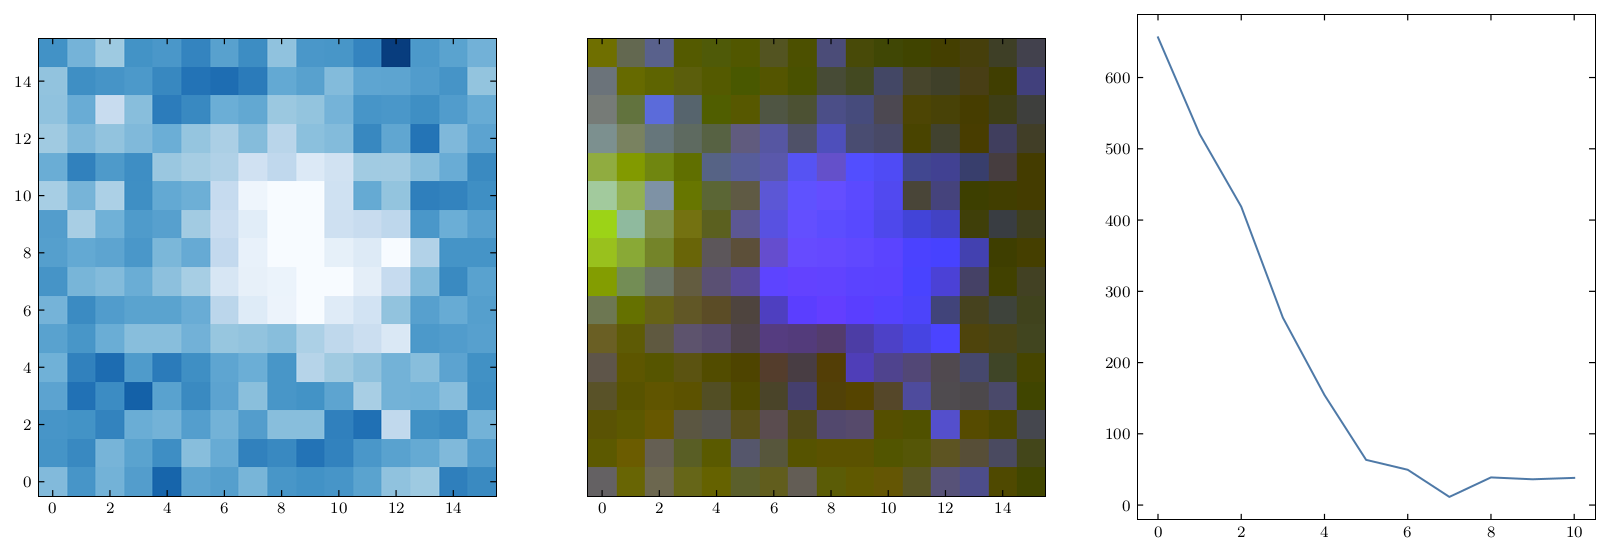

In [279]:
idx = 905                    

row = tmp[tmp['id']==idx]
rgb = single_cutout(galaxy,row['x'],row['y'],size=16)

s = 16
x,y = int(row['x']),int(row['y'])
#print(f'Alam={np.nanmean(Alam[x-s:x+s,y-s:y+s]):.3f}')

## Loop over detection parameters

INFO:pymuse.analyse:initialize fitter with 53 data points
INFO:pymuse.analyse:30.056+0.025-0.169
INFO:pymuse.analyse:initialize fitter with 62 data points
INFO:pymuse.analyse:30.068+0.021-0.147
INFO:pymuse.analyse:initialize fitter with 70 data points
INFO:pymuse.analyse:30.078+0.017-0.131
INFO:pymuse.analyse:initialize fitter with 112 data points
INFO:pymuse.analyse:30.057+0.027-0.099
INFO:pymuse.analyse:initialize fitter with 131 data points
INFO:pymuse.analyse:30.071+0.021-0.085
INFO:pymuse.analyse:initialize fitter with 146 data points
INFO:pymuse.analyse:30.081+0.019-0.077
INFO:pymuse.analyse:initialize fitter with 128 data points
INFO:pymuse.analyse:30.071+0.021-0.087
INFO:pymuse.analyse:initialize fitter with 152 data points
INFO:pymuse.analyse:30.085+0.017-0.073
INFO:pymuse.analyse:initialize fitter with 171 data points
INFO:pymuse.analyse:30.093+0.015-0.065
INFO:pymuse.analyse:initialize fitter with 48 data points
INFO:pymuse.analyse:30.045+0.029-0.189
INFO:pymuse.analyse:init

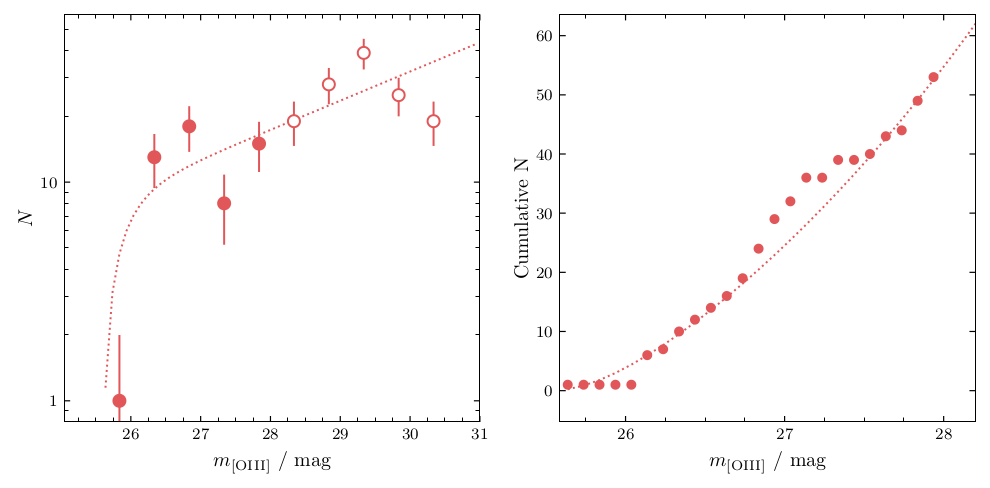

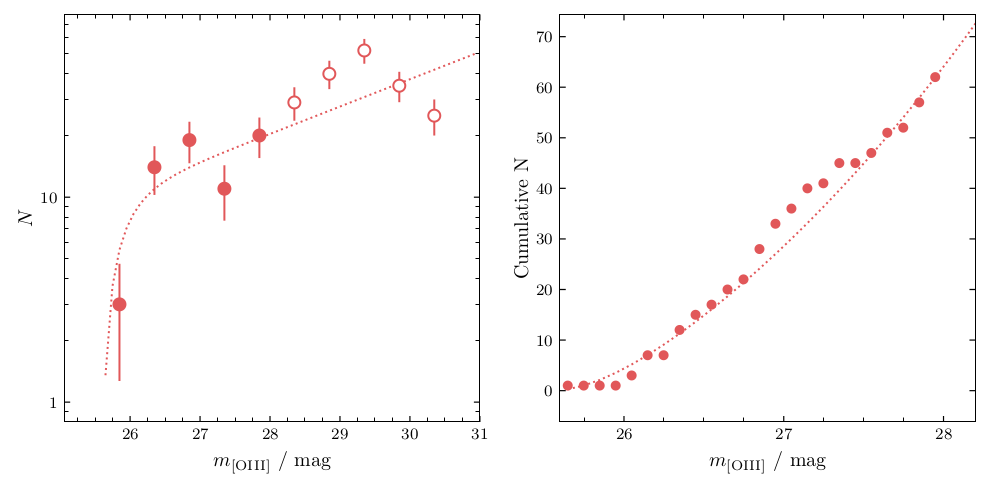

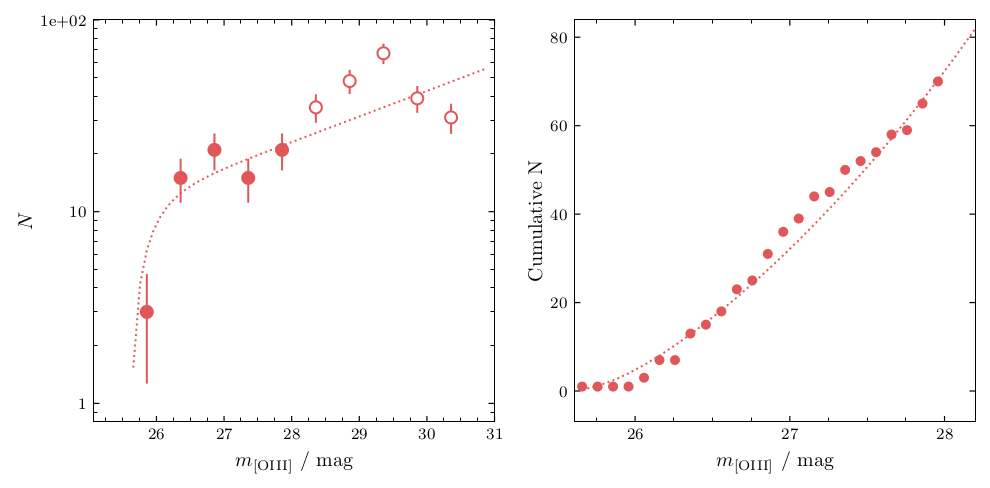

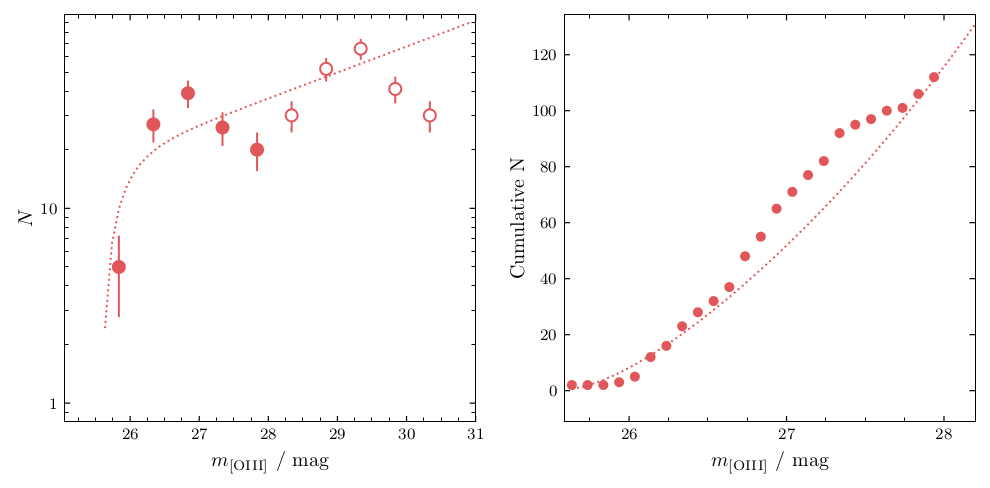

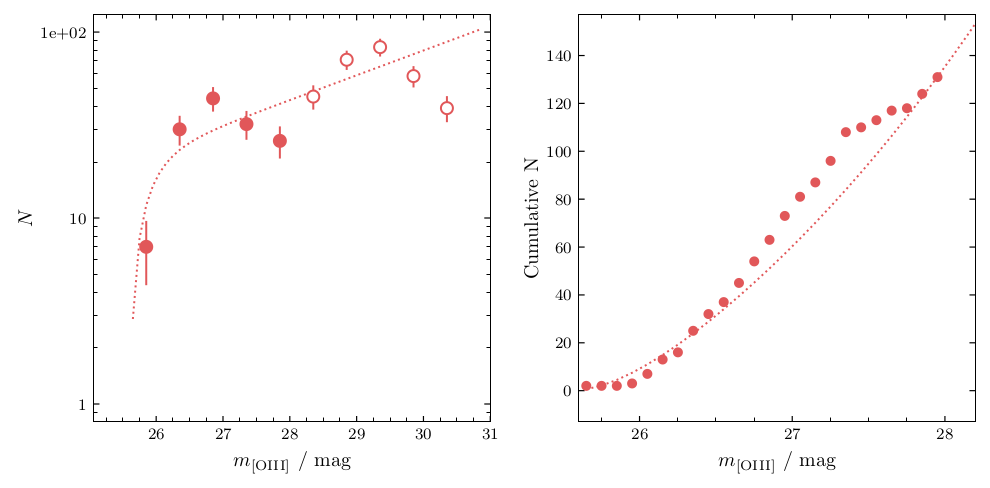

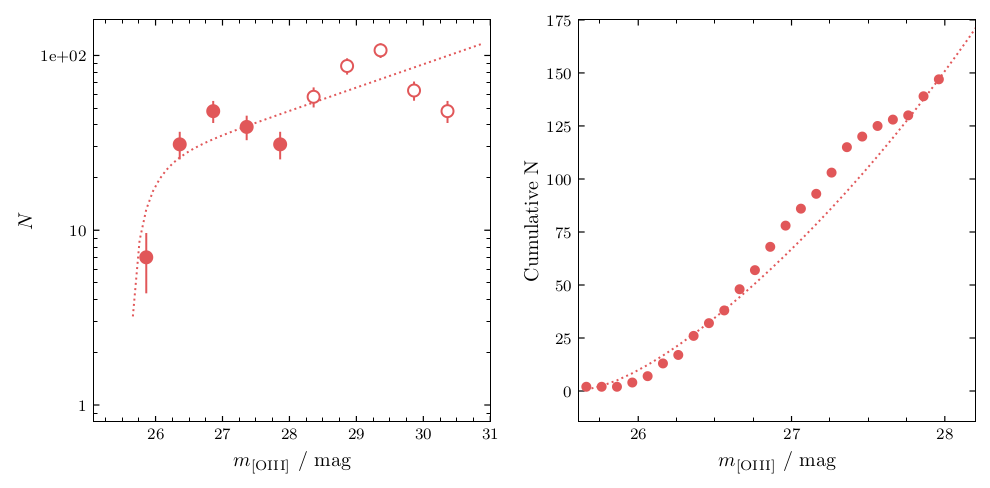

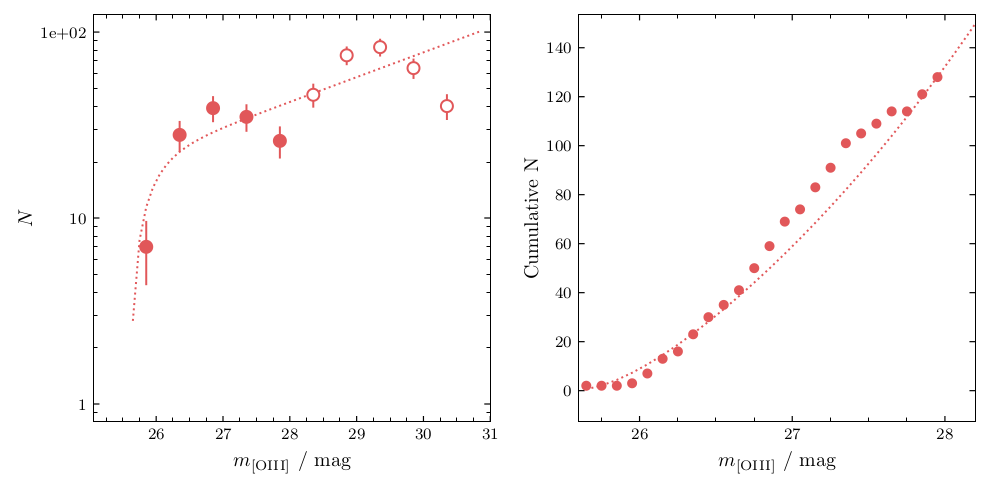

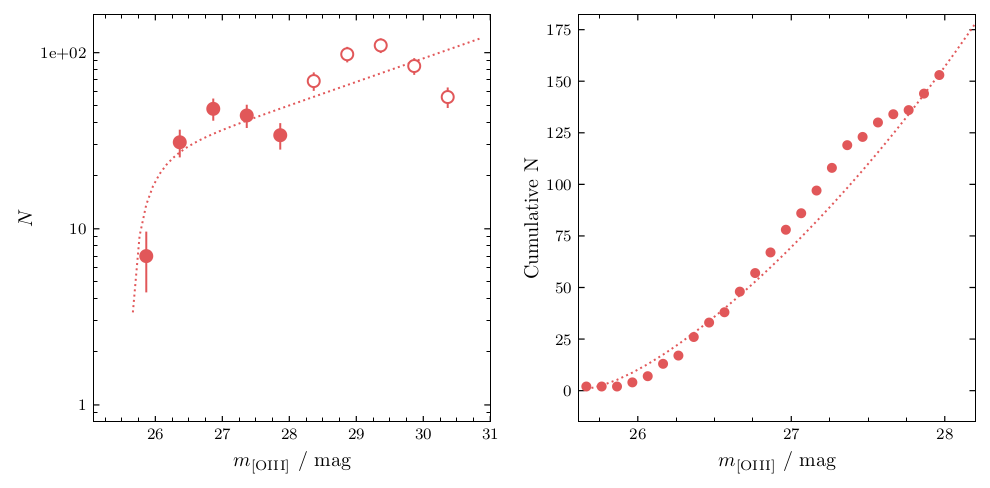

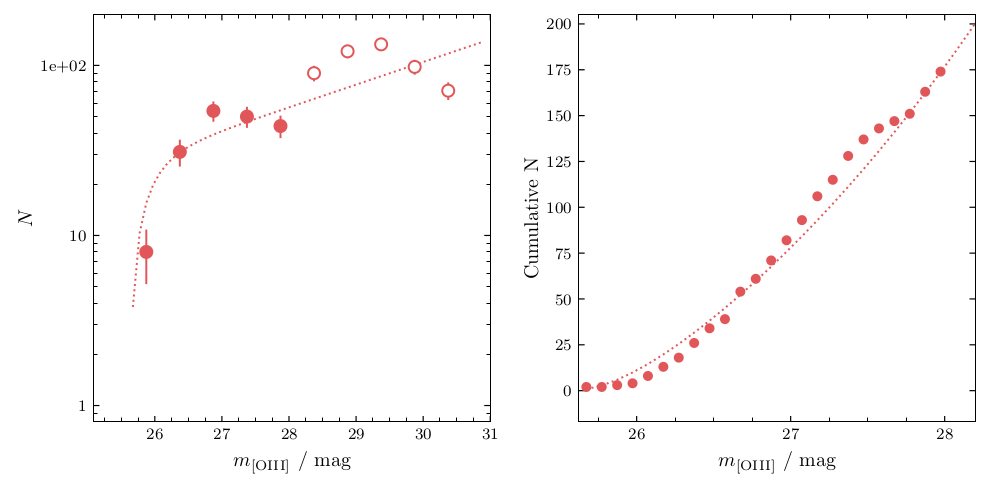

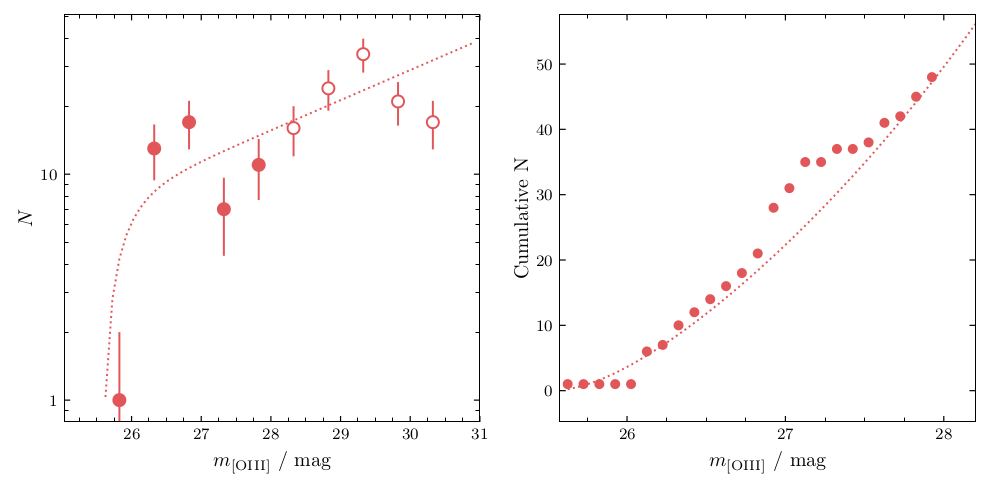

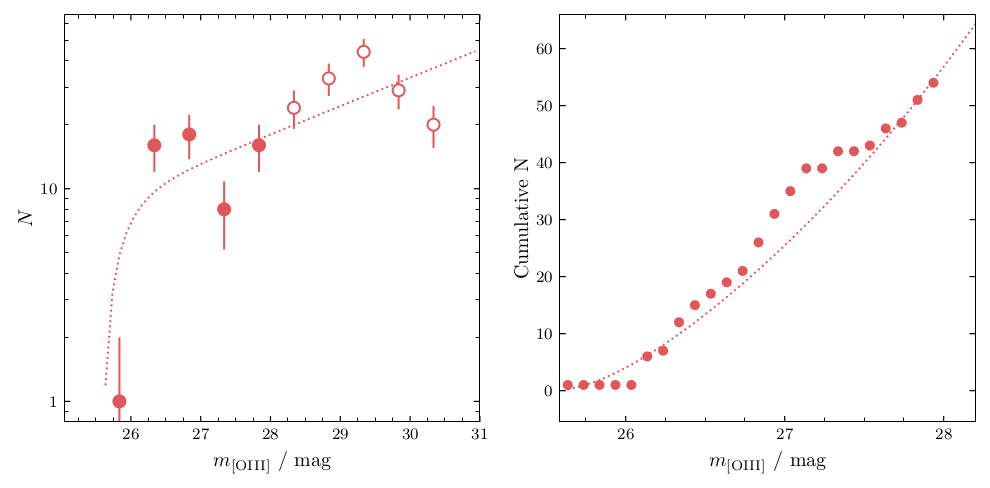

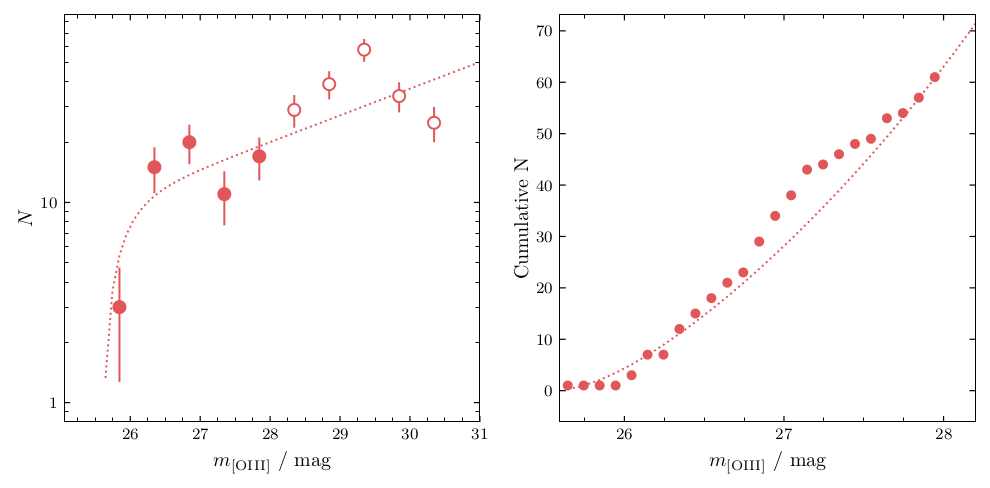

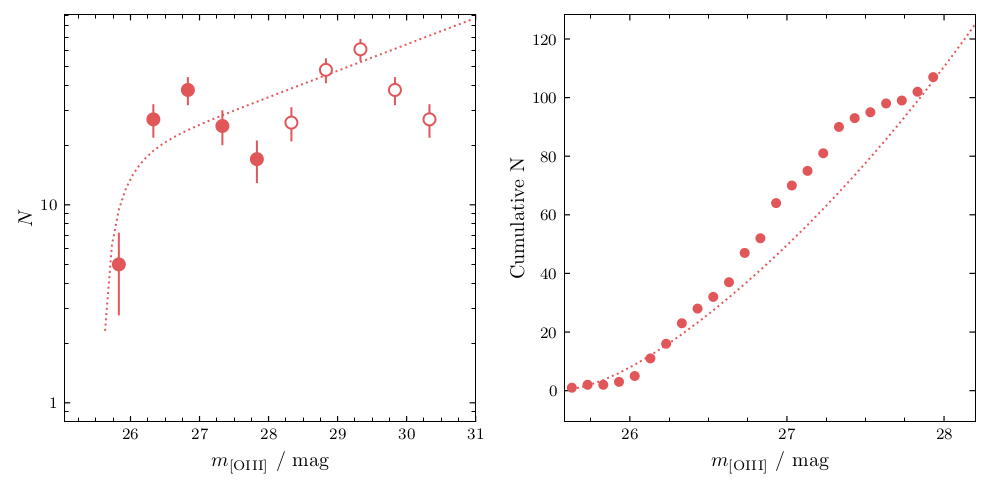

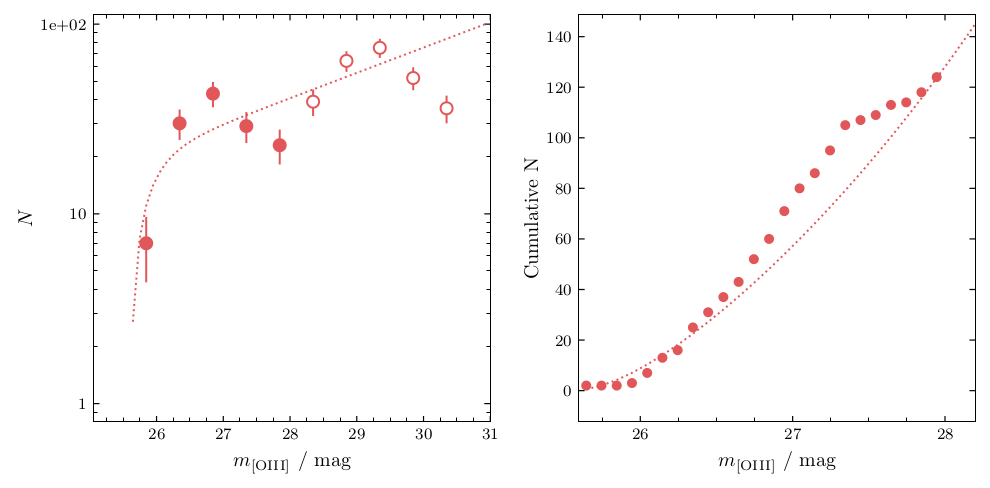

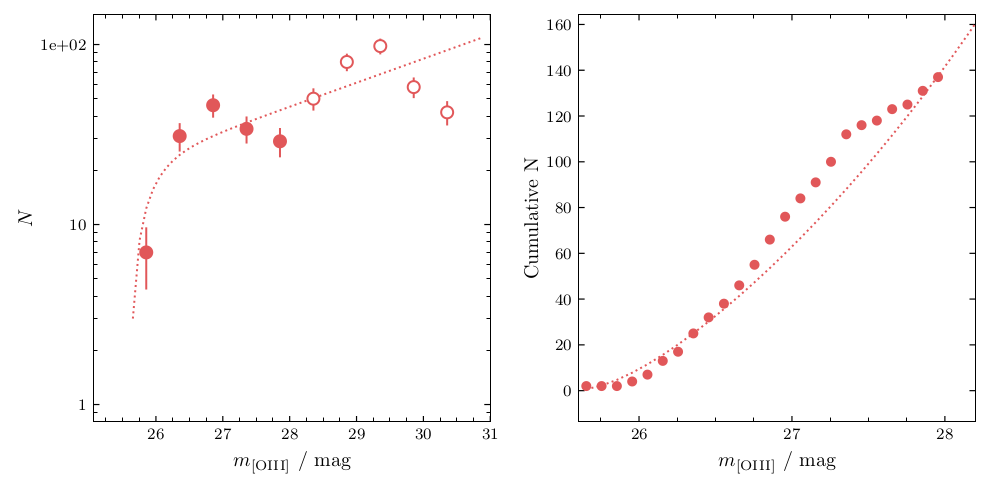

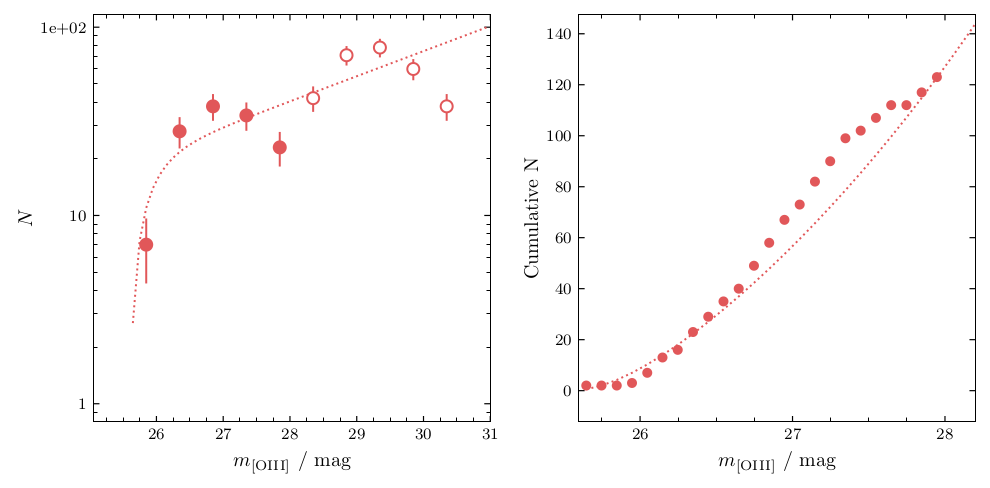

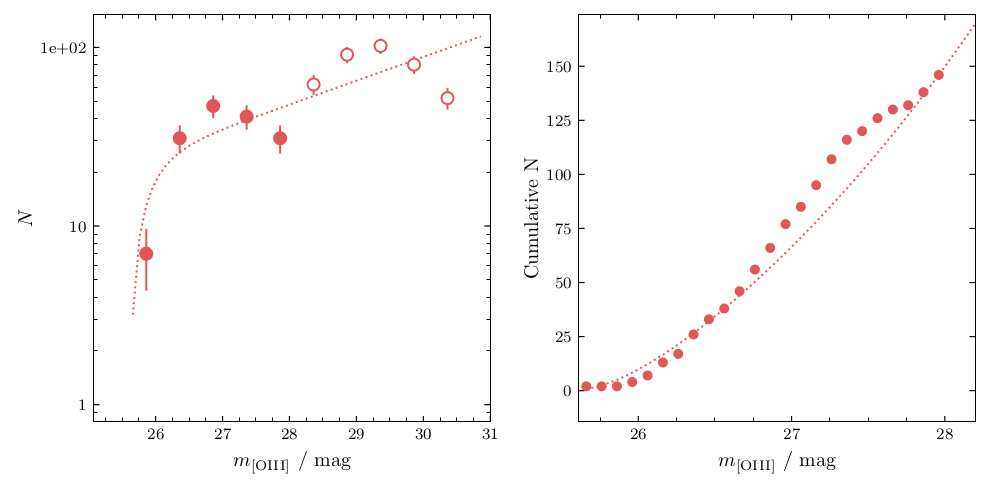

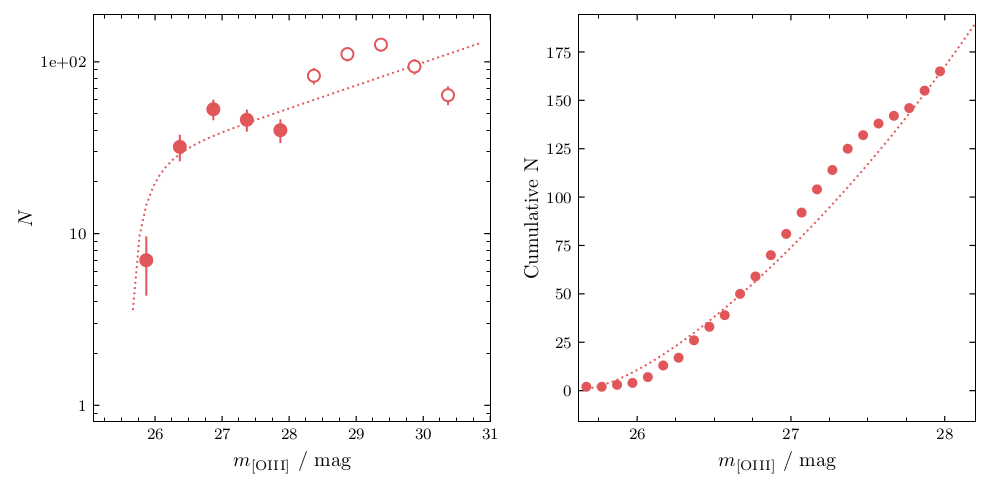

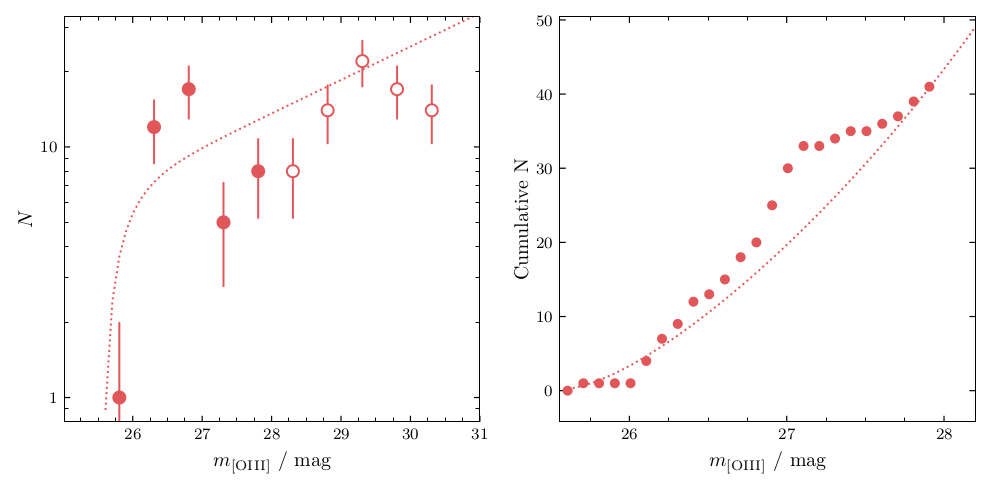

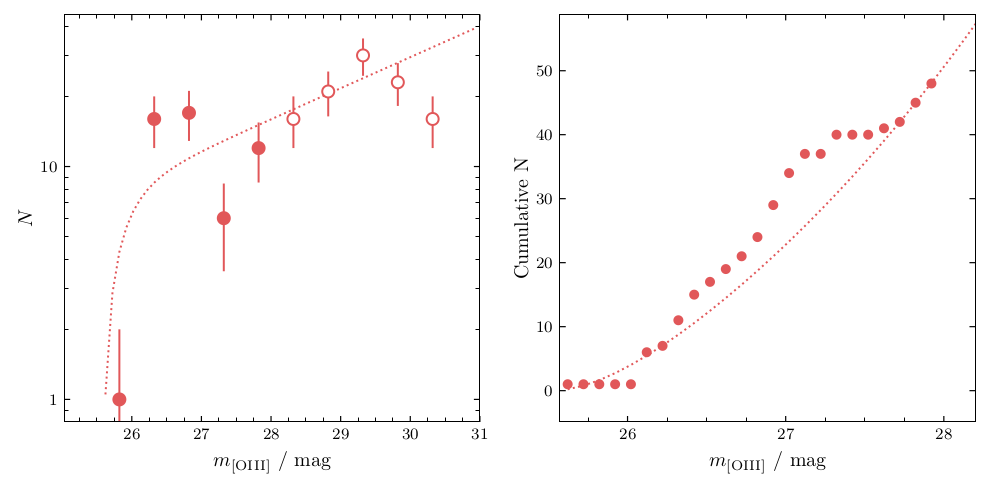

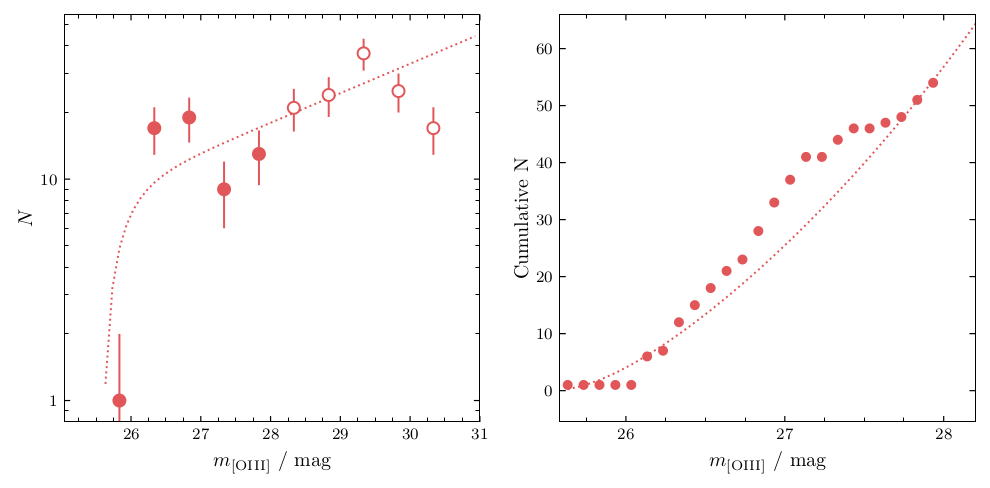

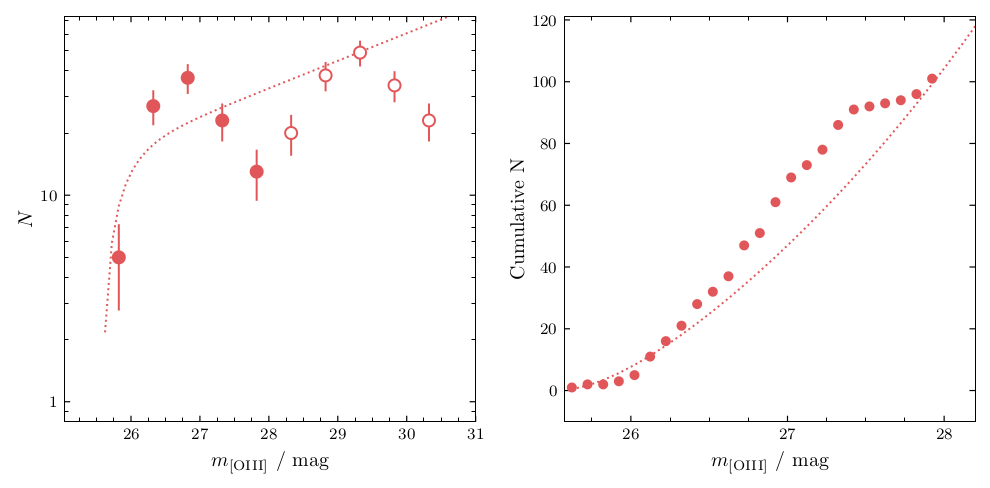

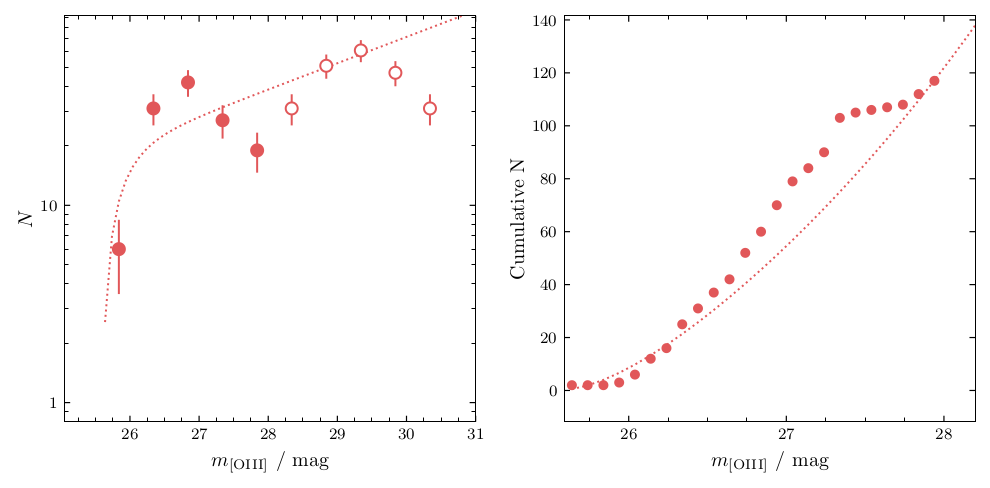

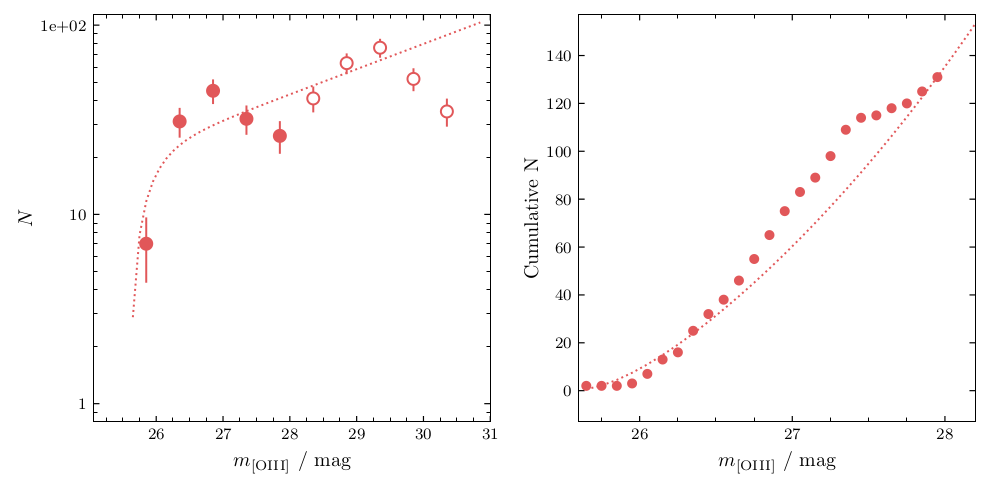

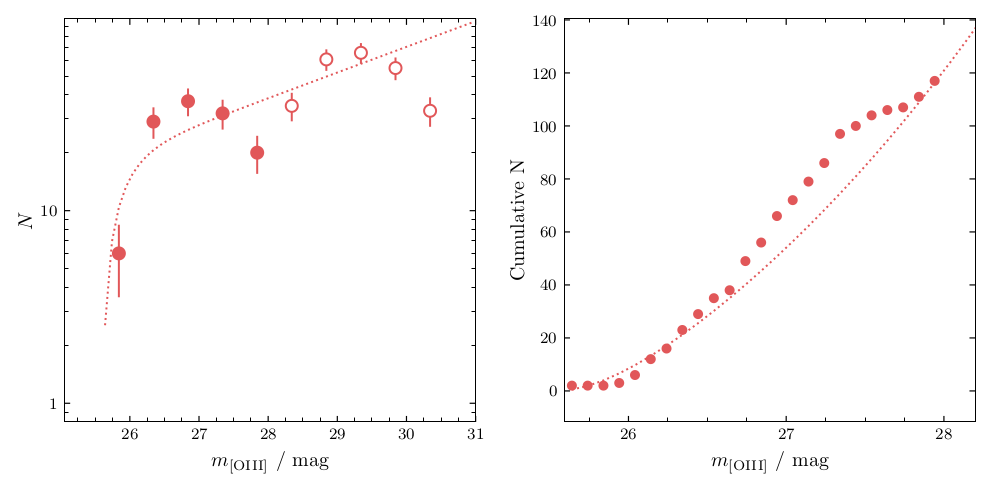

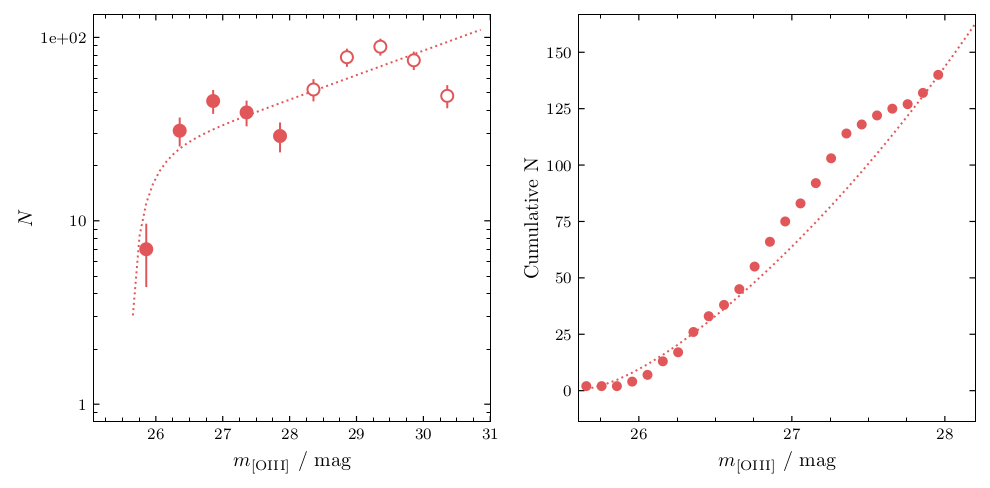

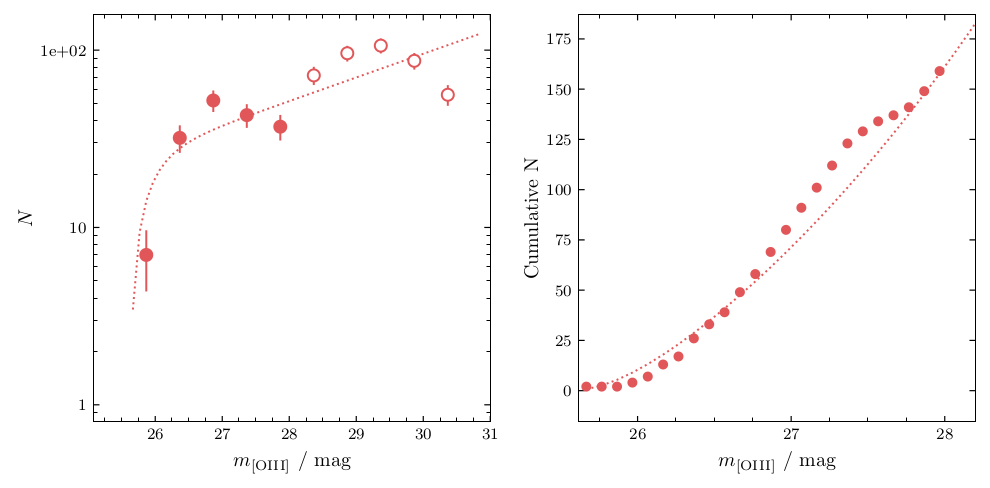

In [160]:
binsize=0.5
#cut = 26.4
for slow in [0,0.1,0.2]:
    for shigh in [0.4,0.6,0.8]:
        for r in [0.4,0.6,0.8]:
            tbl = tbl_old[(sources['sharpness']>slow) & (sources['sharpness']<shigh) & (np.abs(sources['roundness1'])<r)]

            criteria = (tbl['type']=='PN')
            data = tbl[np.where(criteria & (cut<tbl['mOIII']) & (tbl['mOIII']<galaxy.completeness_limit))]['mOIII']

            fitter = MaximumLikelihood1D(pnlf,data,mhigh=galaxy.completeness_limit)
            galaxy.mu,dm_p,dm_m = fitter([24])
            
            filename = basedir / 'reports' / 'test' / f'{10*slow:.0f},{10*shigh:.0f},{10*r:.0f}'
            try:
                axes = plot_pnlf(tbl[criteria]['mOIII'],galaxy.mu,galaxy.completeness_limit,binsize=binsize,mhigh=31,filename=filename,color=tab10[0])
            except:
                pass

## Distance in parsec

the measured distances are in the form of the distance modulus $\mu = m-M$ which is the difference between apparent and absolute magnitude. By defintion of the absolte magnitude, we can convert this number into a distance in pc
$$
d = 10^{\frac{\mu}{5}+1} = 10 \cdot \exp\left( \ln 10 \frac{\mu}{5} \right) \\
\delta d = \frac{\ln 10}{5} 10 \exp\left( \ln 10 \frac{\mu}{5} \right) \delta \mu = 0.2 \ln 10 \; d \; \delta \mu
$$

In [ ]:
def distance_modulus_to_parsec(mu,mu_err=np.array([])):
    
    d = 10 * np.exp(np.log(10)*mu/5)
    if len(mu_err) > 0:
        d_err = 0.2 * np.log(10) * d * mu_err
    print(f'd = ({d/1e6:.2f} + {d_err[0]/1e6:.2f} - {d_err[1]/1e6:.2f}) Mpc')
    
    return d, d_err

d,d_err = distance_modulus_to_parsec(30.033,np.array([0.014,0.015]))

## Compare to other papers

In [19]:
from pymuse.auxiliary import search_table, Distance
from photutils import CircularAperture

raw = ascii.read(basedir / 'data' / 'external' / 'Herrmann_2008_pn_candidates.txt')

raw['RA'] = 12*' '
raw['DEC'] = 13*' '

for row in raw:
    row['RA'] = f'{row["RAh"]:02d}h{row["RAm"]:02d}m{row["RAs"]:.0f}s'
    row['DEC'] = f'{row["DEd"]:02d}d{row["DEm"]:02d}m{row["DEs"]:0f}s'

raw['SkyCoord'] = SkyCoord(raw['RA'],raw['DEC'])

In [ ]:
catalogcoord = tbl[tbl['type']=='PN']

matchcoord   = search_table(raw,'M74')
matchcoord['x'],matchcoord['y']= matchcoord['SkyCoord'].to_pixel(wcs=galaxy.wcs)

In [ ]:
matchcoord   = search_table(raw,'M74')
matchcoord['x'],matchcoord['y']= matchcoord['SkyCoord'].to_pixel(wcs=galaxy.wcs)

matchcoord['in_frame'] = False
y_dim,x_dim = galaxy.shape

for row in matchcoord:
    txt,x,y = row['ID'], row['x']+5, row['y']    
    if 0<=int(x)<x_dim and 0<=int(y)<y_dim:
        if not np.isnan(galaxy.PSF[int(y),int(x)]):
            row['in_frame'] = True

data = [d for d in matchcoord['m5007']]
data = matchcoord[matchcoord['in_frame']]['m5007']

In [ ]:
completeness = 26.6

data = matchcoord[matchcoord['in_frame']]['m5007']
data = data[data<completeness]
fitter = MaximumLikelihood1D(pnlf,
                             np.array(data),
                             mhigh=completeness)


mu,dm_p,dm_m = fitter.plot()

In [ ]:
binsize = 0.25
plot_pnlf(matchcoord['m5007'],29.91,26.5,binsize=binsize,mhigh=28)

In [ ]:
binsize = 0.25
plot_pnlf(matchcoord[matchcoord['in_frame']]['m5007'],29.91,26.5,binsize=binsize,mhigh=28)

In [ ]:
matchcoord=matchcoord[:40]

fig = plt.figure(figsize=(6.974,6.974))
ax1 = fig.add_subplot(111,projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
ax1.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues_r)

ax1.scatter(matchcoord['x'],matchcoord['y'],marker='o',s=2,c='tab:red')
for row in matchcoord:
    txt,x,y = row['ID'], row['x']+5, row['y']    
    ax1.annotate(txt, (x, y),fontsize=4,color='tab:red')
    
plt.savefig('test.pdf',dpi=600)

In [ ]:
#matchcoord = matchcoord[matchcoord['in_frame']][:40]

fig = plt.figure(figsize=(6.974,6.974))
ax1 = fig.add_subplot(111,projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,'linear',clip=False,max_percent=95)
ax1.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues)

positions = np.transpose([matchcoord['x'],matchcoord['y']])
apertures = CircularAperture(positions, r=6)
apertures.plot(color='tab:red',lw=.3, alpha=1,ax=ax1)

positions = np.transpose([catalogcoord['x'],catalogcoord['y']])
apertures = CircularAperture(positions, r=6)
apertures.plot(color='tab:orange',lw=.3, alpha=1,ax=ax1)

for row in matchcoord:
    txt,x,y = row['ID'], row['x']+5, row['y']    
    ax1.annotate(txt, (x, y),fontsize=4,color='tab:red')
    
plt.savefig('test.pdf',dpi=600)

In [ ]:
from astropy.coordinates import match_coordinates_sky # match sources against existing catalog
from astropy.coordinates import Angle                 # work with angles (e.g. 1°2′3″)

tolerance = '0.5s'
ID, angle, Quantity  = match_coordinates_sky(matchcoord['SkyCoord'],catalogcoord['SkyCoord'])
within_tolerance = len(angle[angle.__lt__(Angle(tolerance))])

print(f'{within_tolerance} of {len(angle)} match within {tolerance}": {within_tolerance / len(angle)*100:.1f} %')
print(f'mean seperation is {angle.mean().to_string(u.arcsec,decimal=True)}"')

## Dust extinction etc.

The V-band extinction $A_V$ and the color excess $E(B-V)=(B-V)_\text{obs} - (B-V)_\text{int}$ are related via the selective extinction
$$
A_V = R_V E(B-V)
$$
The extinction at wavelength $\lambda$ can be obtained with the extinction curve
$$
k(\lambda) = \frac{A_\lambda}{E(B-V)}\quad \rightarrow\quad A_\lambda = k(\lambda) E(B-V)
$$
or 
$$
k(\lambda) = \frac{A_\lambda}{A_V} R_V
$$
The color excess can be calculated if the intrinsic ratio of two lines is known
$$
\begin{align}
E(B-V) &= \frac{E(F_2-F_1)}{k(\lambda_2) -k(\lambda_1)} \\
&=\frac{2.5}{k(\lambda_2) - k(\lambda_1)} \log_{10} \left[ \frac{(F_1 / F_2)_\text{obs}}{(F_1 / F_2)_\text{int}} \right] 
\end{align}
$$



`dust_extinction.evaluate` returns $A_\lambda / A_V$, hence we need to multiply with $R_V$ to get $k(\lambda)$


`dust_extinction.extinguish` returns the fractional extinction $f_\lambda$. To get $A_\lambda$ we need to $-2.5\log_{10} f_\lambda$

$$
E(B-V)_\text{star} = 0.44 E(B-V)_\text{nebula}
$$

### Attenuation vs extinction

extinction only considers one ray of light. Therefor it will only decrease the intensity. For attenuation, a larger area and a bundle of light rays is considered. It is possible that light is scattered from one line of sight into another one.

In [46]:
from dust_extinction.parameter_averages import CCM89, F99

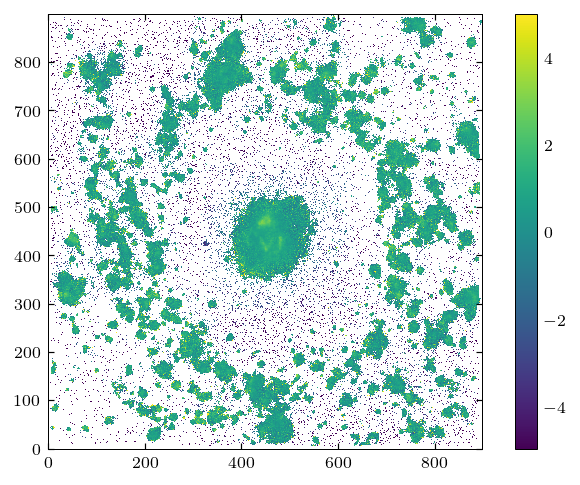

In [48]:
Rv=3.1

ext_model = CCM89(Rv=Rv)
k = lambda lam: ext_model.evaluate(lam*u.angstrom,Rv) * Rv

def calculateEbv(F1,F2,lam1,lam2,Rint):
    '''
    
    Rint : float
        intrinsic flux ratio flux1/flux2
    '''
        
    with np.errstate(divide='ignore', invalid='ignore'):
        Ebv = 2.5 / (k(lam2)-k(lam1)) * np.log10(F1/F2/Rint)
    
    Ebv[~np.isfinite(Ebv)] = np.nan
    
    return Ebv

Ebv = calculateEbv(galaxy.HA6562,galaxy.HB4861,6562,4861,2.86)
Ebv[(galaxy.HB4861 / galaxy.HB4861_err < 5) & (galaxy.HA6562 / galaxy.HA6562_err < 15)] = np.nan

Av = Ebv * Rv


norm = simple_norm(Av,'linear',clip=False,min_cut=-5,max_cut=5)
im = plt.imshow(Av,origin='lower',norm=norm)
plt.colorbar(im)
plt.show()

In [54]:
row = sources[1]

Av = np.array([galaxy.Av[int(row['x']),int(row['y'])] for row in sources])

In [70]:
ext_model.extinguish(5007*u.angstrom,Av=Av)

array([       nan, 0.95619084,        nan, ...,        nan,        nan,
              nan])

In [60]:
x*ext_model.evaluate(5007*u.angstrom,Rv=3.1)

array([0.04863856])

In [74]:
x=0.
10**(-0.4*x*k(5007)/Rv)

array([1.])

In [68]:
ext_model.extinguish(5007*u.angstrom,Av=x)

0.9561908378305632

In [127]:
external = Path('g:/Archive')

with fits.open(external / 'MUSE' / 'AUXILIARY' / 'AVmaps' / 'fits' / f'{galaxy.name}_AV_caseB_negnan_conv_broad_Ha15_Hb5.fits') as hdul:
    AVmap = hdul[0].data

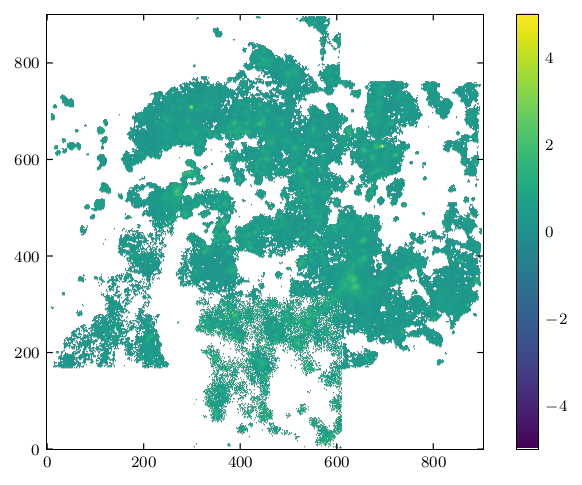

In [138]:
#norm = simple_norm(AVmap,'linear',clip=False,percent=99.9)
im = plt.imshow(AVmap,origin='lower',norm=norm)
plt.colorbar(im)
plt.show()

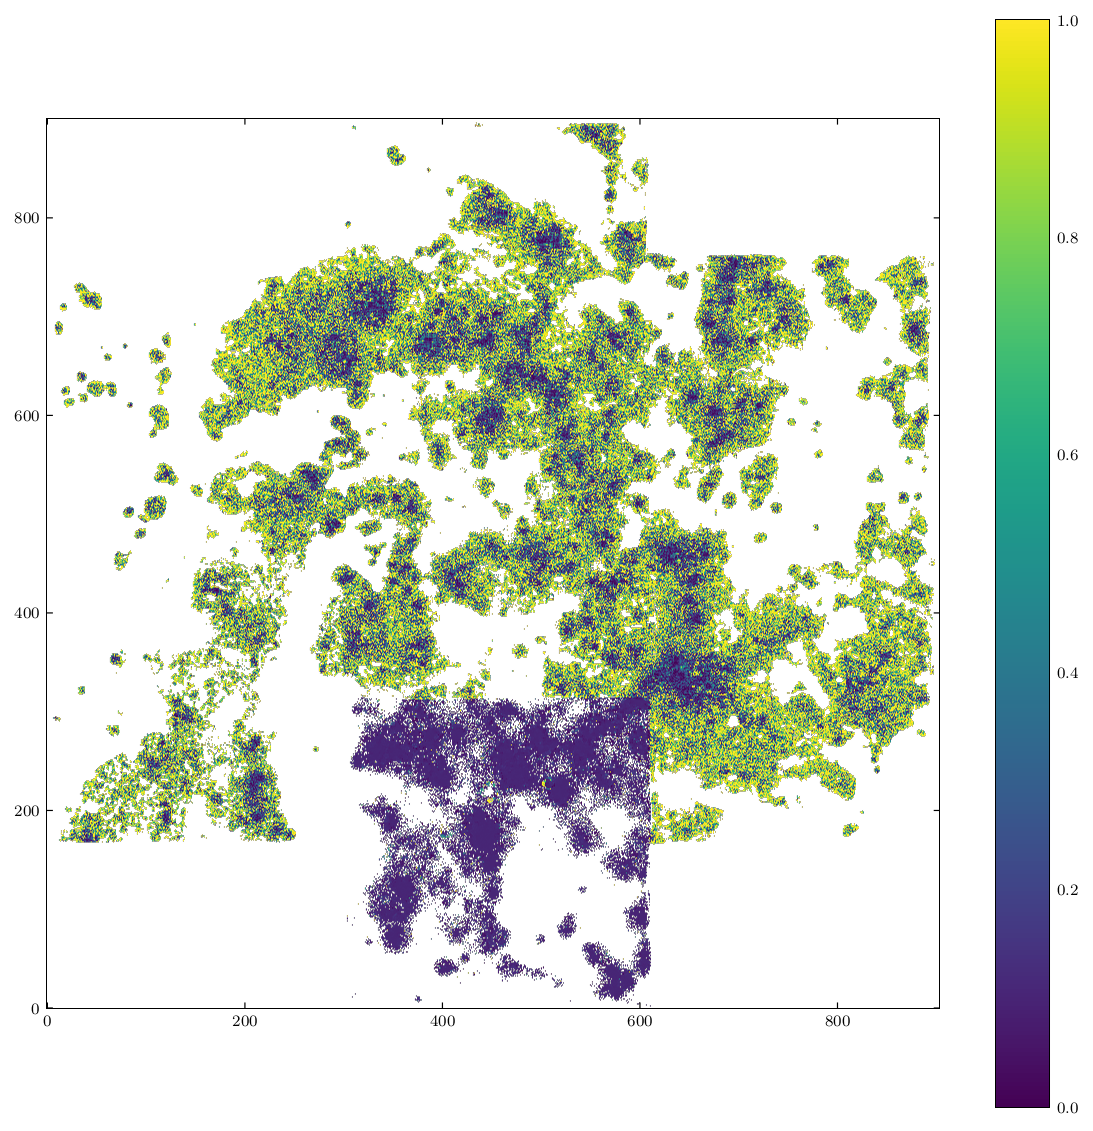

In [131]:
dif = np.abs((AVmap-Av)/Av)
norm = simple_norm(dif,'linear',clip=False,min_cut=0,max_cut=1)
fig = plt.figure(figsize=(10,10))
im = plt.imshow(dif,origin='lower',norm=norm)
plt.colorbar(im)
plt.show()

In [134]:
box_size = 4
xmax, ymax = Av.shape

out = np.zeros(Av.shape)

for i in range(xmax):
    for j in range(ymax):
        mask = slice(max(0,i-box_size),min(i+box_size,xmax)),slice(max(0,j-box_size),min(j+box_size,ymax))        
        out[i,j] = np.nanmean(Av[mask])

In [285]:
np.nanmean(out[(out<np.inf) & (out>-np.inf)])

0.47362994997075547

In [173]:
lam = 5007
Alam =  ext_model.evaluate(lam*u.angstrom,Rv) * AVmap